# Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from tqdm.notebook import tqdm

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
from torch.utils.data import random_split, DataLoader,Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.models import resnet18, ResNet18_Weights
import torchvision.utils as vutils

# Пишем класс датасет (выгрузка данныхх из папки)

In [3]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.image_paths = []
        self.labels = []
        #определяем загрузки для train папкм
        if self.mode == 'train':
            train_dir = os.path.join(self.root_dir, 'train')
            class_folders = os.listdir(train_dir)
            class_folders = [folder for folder in class_folders if folder.isdigit()]
            class_folders = sorted(class_folders, key=lambda x: int(x))#так как папкаи с классами перемешаны, сортируем по классам
            
            for label_str in class_folders:
                label_dir = os.path.join(train_dir, label_str)
                if os.path.isdir(label_dir):
                    image_files = [img for img in os.listdir(label_dir) if img.endswith('.png')]
                    image_files = sorted(image_files) 

                    for img_file in image_files:
                        img_path = os.path.join(label_dir, img_file)
                        self.image_paths.append(img_path)
                        self.labels.append(int(label_str))
        #выгружаем тестовые данные
        elif self.mode == 'test':
            test_dir = os.path.join(self.root_dir, 'test')
            #их сортируем для будущего предикта

            self.image_paths = [
                os.path.join(test_dir, f)
                for f in sorted(os.listdir(test_dir), key=lambda x: int(os.path.splitext(x)[0]))
                if f.endswith('.png')
            ]
            self.labels = None

    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
    

        if self.labels is not None:
            label = self.labels[idx]
        else:
            label = -1 
    
        image = Image.open(image_path).convert("RGB")

        if self.transform:
   
            if isinstance(self.transform, (A.BasicTransform, A.Compose)):
                image_np = np.array(image)
                transformed = self.transform(image=image_np)
                image = transformed['image']
            else:
                image = self.transform(image)

        return image, label

# EDA анализ+анализ классов

In [4]:
#напишем базовый пайплайн для базовой модели и анализа данных в папках (только нормализация и превращение в тензор)
transform_basic = A.Compose([
    #A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),не нужна пока, иначе не рисуется нормально
    ToTensorV2()
])
full_dataset_0 = CustomImageDataset(root_dir='data', mode='train', transform=transform_basic)#без аугментации, для анализа классов и изучения представителей классов
for item in full_dataset_0:
    break
print(item[1])#класс картинки
print(item[0].shape)#размер картинок


0
torch.Size([3, 32, 32])


In [5]:
print(f"Картинок в датасете: {len(full_dataset_0)}")

Картинок в датасете: 9510


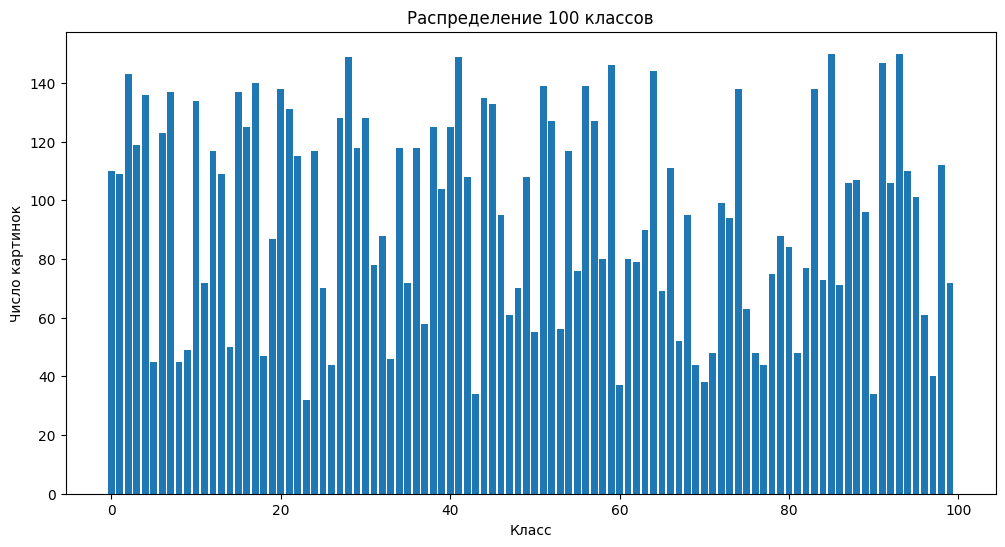

In [6]:
#проверим сбалансированность классов
class_inst = {}
for item in full_dataset_0:
    cur_class = item[1] 
    if cur_class in class_inst:
        class_inst[cur_class] += 1
    else:
        class_inst[cur_class] = 1
plt.figure(figsize=(12, 6))
plt.bar(class_inst.keys(), class_inst.values())
plt.xlabel('Класс')
plt.ylabel('Число картинок')
plt.title('Распределение 100 классов')
plt.show()

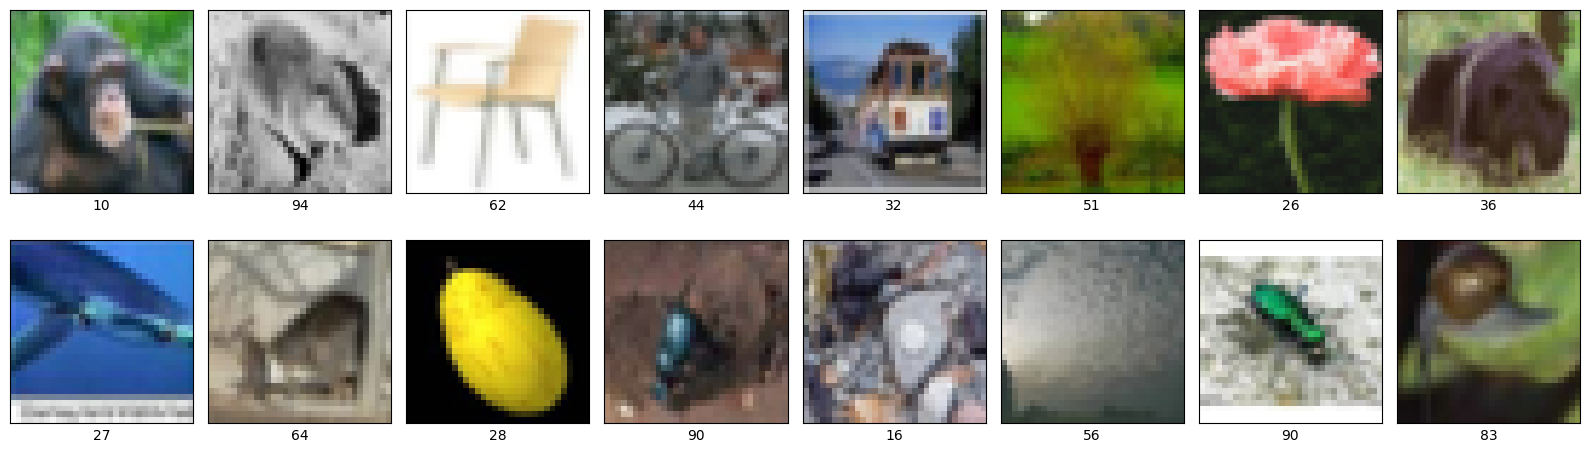

In [7]:
#посмотрим на несколько предстваителей рандомных классов
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols, 2.5 * rows))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(full_dataset_0))
        img, label = full_dataset_0[random_index]
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        img = img.permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.set_xlabel(label)

plt.tight_layout()
plt.show()

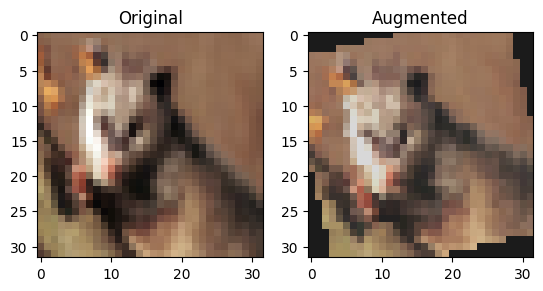

In [8]:
transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
])

img, label = full_dataset_0[0]
augmented_img = transform(img)

plt.subplot(1,2,1)
plt.imshow(img.permute(1,2,0))
plt.title('Original')

plt.subplot(1,2,2)
plt.imshow(augmented_img.permute(1,2,0))
plt.title('Augmented')

plt.show()

Выводы:

 1)в train датасете 9510 картинок размера 32*32*3 и 100 классов
 
 2)Классы распределены не совсем равномерно, но совсем дисбалансных классов нет (где наблюдений меньше 20, так что модель может достаточно хорошо обучиться для каждого класса 

# Аугментация для Train и пайплайн

In [9]:
#это пайплайн с аугментацией для навороченной модели
train_transform = A.Compose([
    #A.Resize(224, 224),
    A.RandomCrop(width=32, height=32),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.2),
    A.CoarseDropout(p=0.3),
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ToTensorV2()
])

val_test_transform = A.Compose([
    #A.Resize(224, 224),
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ToTensorV2()
])



In [10]:
# для базовой модели с отражением по вертикали и тд
basic_train_transform = A.Compose([
    #A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ToTensorV2()
])

In [11]:
#выгружаем данные
full_dataset = CustomImageDataset(root_dir='data',mode='train',transform=None)
dataset_size = len(full_dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.2 * dataset_size)

train_indices, val_indices = torch.utils.data.random_split(range(dataset_size),[train_size, val_size])#сплитуем данные

#выгружаем данные для валидации и трейна
train_dataset = torch.utils.data.Subset(
    CustomImageDataset(root_dir='data',mode='train',transform=train_transform),train_indices)
test_dataset = torch.utils.data.Subset(
    CustomImageDataset(root_dir='data',mode='train',transform=val_test_transform),val_indices)

In [12]:
train_loader = DataLoader(train_dataset,shuffle=True,batch_size=64,num_workers=4)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=64,num_workers=4)

In [13]:
#то же самое на базовый датасет
train_dataset_basic = torch.utils.data.Subset(
    CustomImageDataset(root_dir='data',mode='train',transform=basic_train_transform),train_indices)
test_dataset_basic = torch.utils.data.Subset(
    CustomImageDataset(root_dir='data',mode='train',transform=val_test_transform),val_indices)
train_loader_basic = DataLoader(train_dataset_basic,shuffle=True,batch_size=64,num_workers=4)
test_loader_basic = DataLoader(test_dataset_basic,shuffle=False,batch_size=64,num_workers=4)

# Функции

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [15]:
def accuracy(logits,targets):
    predicted_classes = logits.argmax(dim=1)
    accuracy_value = (predicted_classes==targets).float().mean()
    return accuracy_value

def evaluate(model,test_loader):
    model.eval()
    with torch.no_grad():
        results = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(results)

def get_lr(optimizer):
    return optimizer.param_groups[0]['lr']  

def conv_block(in_channels,out_channels,pool=False):
    block = nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2) if pool else nn.Identity()
    )
    return block

In [16]:
def fit_one_cycle(epochs,max_lr,model,train_loader,test_loader, 
                  weight_decay,grad_clip, opt_func=torch.optim.SGD,
                  stop_lr=1e-5,monitor_metric='val_loss',mode='min'):

    torch.cuda.empty_cache()
    history = []
#здесь вормап реализован в шедулере
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader)
    )

    best_score = float('inf') if mode == 'min' else -float('inf')
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)

            optimizer.step()
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()

        #ранняя остановка
        current_lr = get_lr(optimizer)
        if current_lr < stop_lr:
            print(f"Ранняя остановка {epoch+1}, lr={current_lr:.6f}")
            break

        result = evaluate(model, test_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        #хистори сохраняем для графиков
        #сохряняем метрики модели, чтобы найти лучшую
        score = result[monitor_metric]
        is_better = (score < best_score) if mode == 'min' else (score > best_score)
        if is_better:
            best_score = score
            best_model_state = model.state_dict()

    if best_model_state:
        model.load_state_dict(best_model_state)
        print(f"Лучшая модель ({monitor_metric}={best_score:.4f})")

    return history

In [17]:
#отрисовываем лоси, аккураси и лернинг рейт
def plot_metrics(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['val_loss'] for x in history]
    val_accs = [x['val_acc'] for x in history]
    lrs = history[0]['lrs'] if 'lrs' in history[0] else None
    epochs = range(1, len(history) + 1)
    plt.figure(figsize=(15, 5))

 
    plt.subplot(1, 3, 1)
    plt.plot(epochs,train_losses,label='Train Loss')
    plt.plot(epochs,val_losses,label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Accuracy ans losses')
    plt.legend()
    plt.subplot(1,3,2)
    plt.plot(epochs,val_accs,label='Val Accuracy',color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    if lrs:
        plt.subplot(1, 3, 3)
        plt.plot(range(len(lrs)),lrs,label='Learning Rate',color='red')
        plt.xlabel('Batch')
        plt.ylabel('LR')
        plt.title('Learning Rate Schedule')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Обучим базовую модель

In [18]:
#это базовая модель без навороченных аугментаций, дропаутов, батч нормализаций и прочего
class BasicCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(BasicCNN, self).__init__()
        self.conv1=nn.Conv2d(3,32,kernel_size=3,padding=1)   
        self.conv2=nn.Conv2d(32,64,kernel_size=3,padding=1) 
        self.pool=nn.MaxPool2d(2,2)                           
        self.fc1=nn.Linear(64 * 16 * 16, 128)
        self.fc2=nn.Linear(128,num_classes)
    def forward(self,x):
        x=F.relu(self.conv1(x))        
        x=self.pool(F.relu(self.conv2(x))) 
        x=x.view(x.size(0), -1) 
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x
    def training_step(self, batch):
        images,labels=batch
        images,labels=images.to(self.device),labels.to(self.device)
        out=self(images)
        loss=F.cross_entropy(out,labels)
        return loss
    def validation_step(self,batch):
        images,labels=batch
        images,labels=images.to(self.device),labels.to(self.device)
        out=self(images)
        loss=F.cross_entropy(out,labels)
        acc=accuracy(out, labels)
        return {'val_loss':loss.detach(),'val_acc': acc}
    def validation_epoch_end(self,outputs):
        batch_losses=[x['val_loss'] for x in outputs]
        epoch_loss=torch.stack(batch_losses).mean()
        batch_accs=[x['val_acc'] for x in outputs]
        epoch_acc=torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(),'val_acc': epoch_acc.item()}
    def epoch_end(self,epoch,result):
        print(f"Epoch [{epoch}], last_lr: {result['lrs'][-1]:.5f}, "
              f"train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, "
              f"val_acc: {result['val_acc']:.4f}")
    @property
    def device(self):
        return next(self.parameters()).device

In [19]:
model_1 = BasicCNN(num_classes=100).to(device)
history = fit_one_cycle(epochs=30,max_lr=0.01,
        model=model_1,train_loader=train_loader_basic,
        test_loader=test_loader_basic,weight_decay=1e-4,
        grad_clip=0.1,opt_func=torch.optim.Adam
)

Epoch [0], last_lr: 0.00069, train_loss: 4.2858, val_loss: 3.9652, val_acc: 0.1086
Epoch [1], last_lr: 0.00152, train_loss: 3.6963, val_loss: 3.6120, val_acc: 0.1644
Epoch [2], last_lr: 0.00279, train_loss: 3.3919, val_loss: 3.5131, val_acc: 0.1675
Epoch [3], last_lr: 0.00436, train_loss: 3.1894, val_loss: 3.5034, val_acc: 0.1878
Epoch [4], last_lr: 0.00603, train_loss: 3.1328, val_loss: 3.5532, val_acc: 0.1954
Epoch [5], last_lr: 0.00760, train_loss: 3.1465, val_loss: 3.5776, val_acc: 0.1825
Epoch [6], last_lr: 0.00887, train_loss: 3.1282, val_loss: 3.6267, val_acc: 0.1849
Epoch [7], last_lr: 0.00971, train_loss: 3.1655, val_loss: 3.8045, val_acc: 0.1815
Epoch [8], last_lr: 0.01000, train_loss: 3.0985, val_loss: 3.7689, val_acc: 0.1784
Epoch [9], last_lr: 0.00994, train_loss: 2.9913, val_loss: 3.7621, val_acc: 0.1933
Epoch [10], last_lr: 0.00978, train_loss: 2.8235, val_loss: 3.8100, val_acc: 0.2057
Epoch [11], last_lr: 0.00950, train_loss: 2.7252, val_loss: 3.6423, val_acc: 0.2072
Ep

# Базовая модель с трансфер лернингом

In [20]:
#без враппера нормально не грузилось
class AlbumentationsWrapper:
    def __init__(self,albumentations_transform):
        self.albumentations_transform=albumentations_transform
    def __call__(self,image):
        if not isinstance(image,np.ndarray):
            image=np.array(image)
        return self.albumentations_transform(image=image)["image"]
transfer_train_transform=AlbumentationsWrapper(
    A.Compose([A.Resize(224,224),A.HorizontalFlip(p=0.5),
        A.Normalize(mean=(0.485,0.456,0.406),std=(0.229,0.224,0.225)),
        ToTensorV2()
    ])
)

transfer_val_transform=AlbumentationsWrapper(
    A.Compose([A.Resize(224, 224),A.Normalize(mean=(0.485,0.456,0.406),std=(0.229,0.224,0.225)),
        ToTensorV2()
    ])
)

train_dataset_transfer = torch.utils.data.Subset(
    CustomImageDataset(root_dir='data', mode='train',transform=transfer_train_transform),train_indices)
val_dataset_transfer = torch.utils.data.Subset(
    CustomImageDataset(root_dir='data', mode='train',transform=transfer_val_transform),val_indices)

train_loader_transfer = DataLoader(train_dataset_transfer,batch_size=64,shuffle=True,num_workers=4)
val_loader_transfer = DataLoader(val_dataset_transfer,batch_size=64,shuffle=False,num_workers=4)

In [21]:
#подгрузим резнет 18
class TransferResNet(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.network = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        for param in self.network.parameters():
            param.requires_grad = False
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)
        out = self(images)
        return F.cross_entropy(out, labels)

    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(self.device), labels.to(self.device)
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

    @property
    def device(self):
        return next(self.parameters()).device

In [22]:
model_transfer = to_device(TransferResNet(num_classes=100), device)

history = fit_one_cycle(
    epochs=10,
    max_lr=1e-3,
    model=model_transfer,
    train_loader=train_loader_transfer,
    test_loader=val_loader_transfer,
    weight_decay=1e-4,
    grad_clip=0.1,
    opt_func=torch.optim.Adam
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 40.6MB/s]


Epoch [0], val_loss: 4.3251, val_acc: 0.0649
Epoch [1], val_loss: 3.3357, val_acc: 0.2692
Epoch [2], val_loss: 2.5258, val_acc: 0.4220
Epoch [3], val_loss: 2.1576, val_acc: 0.4643
Epoch [4], val_loss: 1.9824, val_acc: 0.5014
Epoch [5], val_loss: 1.9066, val_acc: 0.5006
Epoch [6], val_loss: 1.8497, val_acc: 0.5253
Epoch [7], val_loss: 1.8149, val_acc: 0.5276
Epoch [8], val_loss: 1.8015, val_acc: 0.5393
Ранняя остановка 10, lr=0.000000
Лучшая модель (val_loss=1.8015)


In [23]:
#за 10 эпох модель обучается значительно лучше, чем базовая 

# Обучим более сложную модель

In [24]:
#epochs = 30
#max_lr = 0.001
#grad_clip = 0.01
#weight_decay =0.001
#opt_func = torch.optim.Adam

In [25]:

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images = images.to(next(self.parameters()).device) #кидаем тензор на устройство
        labels = labels.to(next(self.parameters()).device)
        out = self(images)                 
        loss = F.cross_entropy(out,labels) #считаем лос
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        images = images.to(next(self.parameters()).device)
        labels = labels.to(next(self.parameters()).device)
        out = self(images)                   
        loss = F.cross_entropy(out, labels)  
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()  
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()   
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        

class AdvModel(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True) 
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) 
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True) 
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512)) 
        self.conv5 = conv_block(512, 1028, pool=True) 
        self.res3 = nn.Sequential(conv_block(1028, 1028), conv_block(1028, 1028))  
        
        self.classifier = nn.Sequential(nn.MaxPool2d(2),
                                        nn.Flatten(), 
                                        nn.Linear(1028, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.conv5(out)
        out = self.res3(out) + out
        out = self.classifier(out)
        return out

model = to_device(AdvModel(3, 100), device)
model

AdvModel(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Identity()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Identity()
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_run

In [26]:
history = fit_one_cycle(epochs=30,max_lr=0.001,
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    weight_decay=0.001,
    grad_clip=0.01,
    opt_func=torch.optim.Adam,
    stop_lr=1e-5, 
    monitor_metric='val_acc',  
    mode='max' 
)

Epoch [0], last_lr: 0.00007, train_loss: 4.2832, val_loss: 3.8212, val_acc: 0.1246
Epoch [1], last_lr: 0.00015, train_loss: 3.8234, val_loss: 3.7296, val_acc: 0.1464
Epoch [2], last_lr: 0.00028, train_loss: 3.7196, val_loss: 3.7238, val_acc: 0.1678
Epoch [3], last_lr: 0.00044, train_loss: 3.6367, val_loss: 3.9364, val_acc: 0.1739
Epoch [4], last_lr: 0.00060, train_loss: 3.5951, val_loss: 3.7663, val_acc: 0.1736
Epoch [5], last_lr: 0.00076, train_loss: 3.5374, val_loss: 3.6197, val_acc: 0.1853
Epoch [6], last_lr: 0.00089, train_loss: 3.3397, val_loss: 3.6442, val_acc: 0.1945
Epoch [7], last_lr: 0.00097, train_loss: 3.2219, val_loss: 3.5252, val_acc: 0.2223
Epoch [8], last_lr: 0.00100, train_loss: 3.0581, val_loss: 3.3874, val_acc: 0.2445
Epoch [9], last_lr: 0.00099, train_loss: 2.8687, val_loss: 3.4203, val_acc: 0.2504
Epoch [10], last_lr: 0.00098, train_loss: 2.7082, val_loss: 3.2842, val_acc: 0.2551
Epoch [11], last_lr: 0.00095, train_loss: 2.5524, val_loss: 2.6212, val_acc: 0.3674
Ep

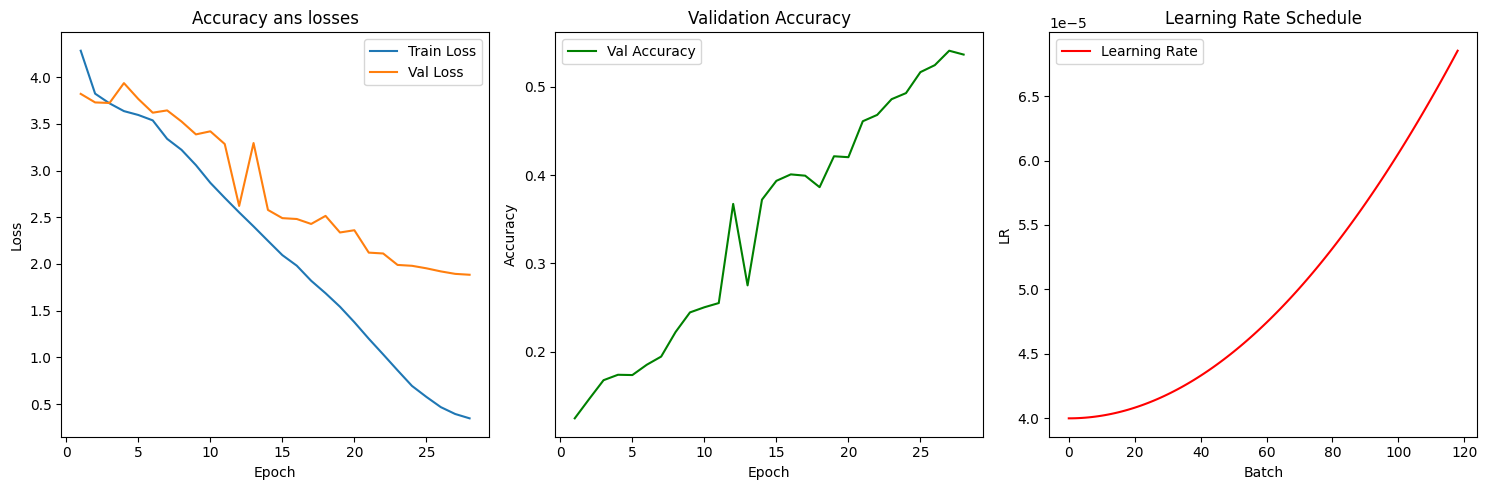

In [27]:
plot_metrics(history)

In [28]:
#эта модель использовалась для предикта

# Модель с генератором данных (DCGAN)

In [29]:
channels = 3 
img_size = 32 
img_shape = (channels, img_size, img_size)
latent_dim = 100
cuda = True if torch.cuda.is_available() else False

In [30]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        
        def block(input_features,output_features,normalize=True):
            layers = [nn.Linear(input_features,output_features)]
            if normalize: 
                layers.append(nn.BatchNorm1d(output_features,0.8))
            layers.append(nn.LeakyReLU(0.2,inplace=True))
            return layers 
        self.model = nn.Sequential(
            *block(latent_dim,128,normalize=False), 
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024,int(np.prod(img_shape))),
            nn.Tanh() 
        )

    def forward(self, z): 
        img = self.model(z)
        img = img.view(img.size(0), *img_shape) 
        return img

In [31]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)),512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid() 
        )
    
    def forward(self, img):
        img_flat = img.view(img.size(0), -1) 
        validity = self.model(img_flat)
        return validity

In [32]:
adversarial_loss = torch.nn.BCELoss()
generator = Generator()
discriminator = Discriminator()
if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

In [33]:
b1 = 0.5
b2 = 0.999
lr = 0.0002 
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1,b2))
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [34]:
from torch.autograd import Variable

In [35]:
n_epochs = 100
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(tqdm(train_loader)): 

        valid = Variable(Tensor(imgs.size(0),1).fill_(1.0),requires_grad=False)
        fake = Variable(Tensor(imgs.size(0),1).fill_(0.0),requires_grad=False)  

        real_imgs = imgs.type(Tensor)
#тепрь генератор
        optimizer_G.zero_grad()
 
        z = Tensor(np.random.normal(0, 1,(imgs.shape[0],latent_dim)))

        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs),valid)
        g_loss.backward()
        optimizer_G.step()
#дискриминатор
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs),valid) 
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()),fake)                                                                 
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward() 
        optimizer_D.step()
        sample_z_in_train = Tensor(np.random.normal(0, 1, (imgs.shape[0],latent_dim)))
        sample_gen_imgs_in_train = generator(sample_z_in_train).detach().cpu()
        
        if ((i+1) % 200) == 0: 
            nrow=1
            ncols=5
            fig, axes = plt.subplots(nrows=nrow,ncols=ncols, figsize=(8,2))
            plt.suptitle('EPOCH : {} | BATCH(ITERATION) : {}'.format(epoch+1, i+1))
            for ncol in range(ncols):
                axes[ncol].imshow(sample_gen_imgs_in_train.permute(0,2,3,1)[ncol], cmap='gray')
                axes[ncol].axis('off')
            plt.show()
    print(
        "[Epoch: %d/%d] [Batch: %d/%d] [D loss: %f] [G loss: %f]"
        % (epoch+1, n_epochs, i+1, len(train_loader), d_loss.item(), g_loss.item()))

  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 1/100] [Batch: 119/119] [D loss: 0.276797] [G loss: 1.011754]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 2/100] [Batch: 119/119] [D loss: 0.305035] [G loss: 1.084622]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 3/100] [Batch: 119/119] [D loss: 0.294979] [G loss: 1.147292]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 4/100] [Batch: 119/119] [D loss: 0.252580] [G loss: 1.556112]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 5/100] [Batch: 119/119] [D loss: 0.224898] [G loss: 1.383060]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 6/100] [Batch: 119/119] [D loss: 0.192745] [G loss: 1.753326]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 7/100] [Batch: 119/119] [D loss: 0.173386] [G loss: 2.045395]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 8/100] [Batch: 119/119] [D loss: 0.145495] [G loss: 1.970683]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 9/100] [Batch: 119/119] [D loss: 0.108065] [G loss: 2.282028]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 10/100] [Batch: 119/119] [D loss: 0.165610] [G loss: 2.247403]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 11/100] [Batch: 119/119] [D loss: 0.158828] [G loss: 2.289447]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 12/100] [Batch: 119/119] [D loss: 0.152076] [G loss: 2.250702]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 13/100] [Batch: 119/119] [D loss: 0.302106] [G loss: 2.093405]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 14/100] [Batch: 119/119] [D loss: 0.124743] [G loss: 2.060512]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 15/100] [Batch: 119/119] [D loss: 0.174050] [G loss: 2.018941]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 16/100] [Batch: 119/119] [D loss: 0.144733] [G loss: 2.156713]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 17/100] [Batch: 119/119] [D loss: 0.108947] [G loss: 2.152793]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 18/100] [Batch: 119/119] [D loss: 0.107616] [G loss: 2.201590]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 19/100] [Batch: 119/119] [D loss: 0.189873] [G loss: 2.805009]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 20/100] [Batch: 119/119] [D loss: 0.213474] [G loss: 2.102870]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 21/100] [Batch: 119/119] [D loss: 0.191767] [G loss: 2.037653]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 22/100] [Batch: 119/119] [D loss: 0.295905] [G loss: 3.059422]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 23/100] [Batch: 119/119] [D loss: 0.119082] [G loss: 2.837327]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 24/100] [Batch: 119/119] [D loss: 0.322002] [G loss: 1.938874]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 25/100] [Batch: 119/119] [D loss: 0.215970] [G loss: 2.577158]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 26/100] [Batch: 119/119] [D loss: 0.189830] [G loss: 2.070974]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 27/100] [Batch: 119/119] [D loss: 0.141688] [G loss: 2.455048]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 28/100] [Batch: 119/119] [D loss: 0.194534] [G loss: 2.547744]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 29/100] [Batch: 119/119] [D loss: 0.120394] [G loss: 2.154577]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 30/100] [Batch: 119/119] [D loss: 0.246868] [G loss: 2.413522]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 31/100] [Batch: 119/119] [D loss: 0.279562] [G loss: 2.006667]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 32/100] [Batch: 119/119] [D loss: 0.155711] [G loss: 2.536396]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 33/100] [Batch: 119/119] [D loss: 0.217110] [G loss: 2.574484]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 34/100] [Batch: 119/119] [D loss: 0.177469] [G loss: 2.842422]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 35/100] [Batch: 119/119] [D loss: 0.198980] [G loss: 2.620657]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 36/100] [Batch: 119/119] [D loss: 0.153843] [G loss: 2.864476]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 37/100] [Batch: 119/119] [D loss: 0.161165] [G loss: 2.553497]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 38/100] [Batch: 119/119] [D loss: 0.170095] [G loss: 2.824549]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 39/100] [Batch: 119/119] [D loss: 0.229299] [G loss: 2.293763]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 40/100] [Batch: 119/119] [D loss: 0.208979] [G loss: 3.555490]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 41/100] [Batch: 119/119] [D loss: 0.287548] [G loss: 2.308989]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 42/100] [Batch: 119/119] [D loss: 0.181025] [G loss: 2.436328]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 43/100] [Batch: 119/119] [D loss: 0.124169] [G loss: 2.534946]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 44/100] [Batch: 119/119] [D loss: 0.148052] [G loss: 2.203298]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 45/100] [Batch: 119/119] [D loss: 0.145121] [G loss: 2.355784]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 46/100] [Batch: 119/119] [D loss: 0.278440] [G loss: 2.821736]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 47/100] [Batch: 119/119] [D loss: 0.299202] [G loss: 2.703568]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 48/100] [Batch: 119/119] [D loss: 0.131792] [G loss: 3.254280]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 49/100] [Batch: 119/119] [D loss: 0.112049] [G loss: 3.282476]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 50/100] [Batch: 119/119] [D loss: 0.141210] [G loss: 3.286157]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 51/100] [Batch: 119/119] [D loss: 0.363205] [G loss: 2.877632]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 52/100] [Batch: 119/119] [D loss: 0.322000] [G loss: 2.710918]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 53/100] [Batch: 119/119] [D loss: 0.211944] [G loss: 2.619720]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 54/100] [Batch: 119/119] [D loss: 0.185352] [G loss: 2.423753]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 55/100] [Batch: 119/119] [D loss: 0.184282] [G loss: 2.686539]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 56/100] [Batch: 119/119] [D loss: 0.253167] [G loss: 2.328629]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 57/100] [Batch: 119/119] [D loss: 0.197816] [G loss: 2.702744]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 58/100] [Batch: 119/119] [D loss: 0.216757] [G loss: 2.315917]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 59/100] [Batch: 119/119] [D loss: 0.186287] [G loss: 3.468833]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 60/100] [Batch: 119/119] [D loss: 0.226044] [G loss: 2.344054]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 61/100] [Batch: 119/119] [D loss: 0.290014] [G loss: 2.718395]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 62/100] [Batch: 119/119] [D loss: 0.183498] [G loss: 3.092528]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 63/100] [Batch: 119/119] [D loss: 0.127154] [G loss: 2.340019]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 64/100] [Batch: 119/119] [D loss: 0.176426] [G loss: 2.691741]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 65/100] [Batch: 119/119] [D loss: 0.291648] [G loss: 2.903255]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 66/100] [Batch: 119/119] [D loss: 0.187592] [G loss: 2.813371]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 67/100] [Batch: 119/119] [D loss: 0.161369] [G loss: 2.267181]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 68/100] [Batch: 119/119] [D loss: 0.255607] [G loss: 2.379218]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 69/100] [Batch: 119/119] [D loss: 0.126699] [G loss: 2.539584]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 70/100] [Batch: 119/119] [D loss: 0.221996] [G loss: 3.075410]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 71/100] [Batch: 119/119] [D loss: 0.203435] [G loss: 2.945977]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 72/100] [Batch: 119/119] [D loss: 0.195201] [G loss: 2.598233]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 73/100] [Batch: 119/119] [D loss: 0.219433] [G loss: 2.757442]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 74/100] [Batch: 119/119] [D loss: 0.209739] [G loss: 2.143539]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 75/100] [Batch: 119/119] [D loss: 0.196606] [G loss: 2.895274]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 76/100] [Batch: 119/119] [D loss: 0.296283] [G loss: 2.452370]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 77/100] [Batch: 119/119] [D loss: 0.164754] [G loss: 2.714877]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 78/100] [Batch: 119/119] [D loss: 0.275655] [G loss: 2.230437]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 79/100] [Batch: 119/119] [D loss: 0.209655] [G loss: 3.016849]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 80/100] [Batch: 119/119] [D loss: 0.217464] [G loss: 2.297614]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 81/100] [Batch: 119/119] [D loss: 0.206196] [G loss: 2.290372]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 82/100] [Batch: 119/119] [D loss: 0.285749] [G loss: 2.404214]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 83/100] [Batch: 119/119] [D loss: 0.234435] [G loss: 2.300222]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 84/100] [Batch: 119/119] [D loss: 0.174041] [G loss: 2.780854]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 85/100] [Batch: 119/119] [D loss: 0.158920] [G loss: 2.850631]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 86/100] [Batch: 119/119] [D loss: 0.229514] [G loss: 2.539531]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 87/100] [Batch: 119/119] [D loss: 0.188586] [G loss: 2.804878]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 88/100] [Batch: 119/119] [D loss: 0.191367] [G loss: 2.135504]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 89/100] [Batch: 119/119] [D loss: 0.200536] [G loss: 2.881351]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 90/100] [Batch: 119/119] [D loss: 0.166724] [G loss: 2.882012]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 91/100] [Batch: 119/119] [D loss: 0.193069] [G loss: 2.669895]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 92/100] [Batch: 119/119] [D loss: 0.316326] [G loss: 3.026190]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 93/100] [Batch: 119/119] [D loss: 0.310360] [G loss: 2.466489]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 94/100] [Batch: 119/119] [D loss: 0.244145] [G loss: 2.518806]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 95/100] [Batch: 119/119] [D loss: 0.178107] [G loss: 2.209682]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 96/100] [Batch: 119/119] [D loss: 0.169704] [G loss: 2.963601]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 97/100] [Batch: 119/119] [D loss: 0.201600] [G loss: 2.976677]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 98/100] [Batch: 119/119] [D loss: 0.211312] [G loss: 2.589715]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 99/100] [Batch: 119/119] [D loss: 0.157037] [G loss: 2.585072]


  0%|          | 0/119 [00:00<?, ?it/s]

[Epoch: 100/100] [Batch: 119/119] [D loss: 0.291724] [G loss: 2.898538]


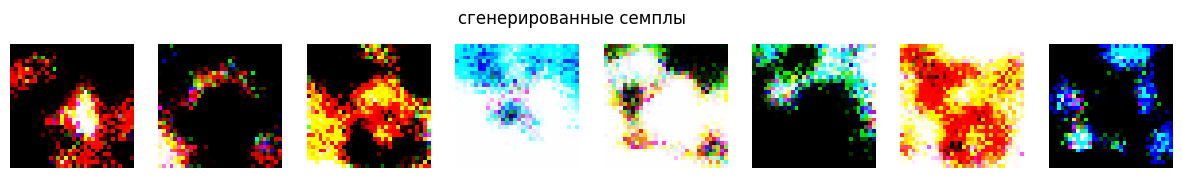

In [36]:
#посмотрим, что сгенерировало и поймем, что ничего не работает
generator.eval()

n_samples = 8  
z = torch.randn(n_samples, latent_dim).to(device) 
with torch.no_grad():
    gen_imgs = generator(z).detach().cpu()
gen_imgs = (gen_imgs + 1) / 2
fig, axes = plt.subplots(1, n_samples, figsize=(15, 2))
for i in range(n_samples):
    img = gen_imgs[i].permute(1, 2, 0).numpy()  
    axes[i].imshow(img)
    axes[i].axis("off")
plt.suptitle("сгенерированные семплы")
plt.show()

генератор очень нестабильно обучается (и очень плохо как видно). Также это обычный GAN (conditional не работал. поэтому в генерации не учитываются классы модели

# Делаем предикт

In [41]:
predict_transform= A.Compose([
    #A.Resize(224, 224),
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
    ToTensorV2()
])

In [42]:
test_predict = CustomImageDataset(root_dir='data', mode='test', transform=predict_transform)
test_predict_loader = DataLoader(test_predict, shuffle=False, batch_size=64, num_workers=4)


In [43]:
print(val_size)

1902


In [44]:

# Store predictions
all_preds = []

with torch.no_grad():  # no gradient computation during inference
    for batch in test_predict_loader:
        # If dataset returns only images without labels:
        if isinstance(batch, (list, tuple)):
            images = batch[0]  # in case dataset returns (img, label) tuple
        else:
            images = batch
        
        images = images.to(device)
        
        # Forward pass
        outputs = model(images)
        
        # Get predicted classes
        _, preds = torch.max(outputs, dim=1)
        
        # Move predictions to CPU and store
        all_preds.append(preds.cpu())

# Concatenate all batches
all_preds = torch.cat(all_preds)

print(all_preds.shape)  # should be (number_of_test_images,)
print(all_preds)

torch.Size([3878])
tensor([15, 62, 18,  ..., 95, 91, 75])


In [46]:
predictions = all_preds.numpy()

# Create DataFrame with the exact required column names
df = pd.DataFrame({
    'id': list(range(len(predictions))),
    'target': predictions
})

# Save to CSV
df.to_csv('predictions_15.csv', index=False)